hello,  here I've attempted to forecast the Domestic RPM using ARIMA and SARIMA models. Any tips or feedback would be much appreciated

In [1]:
# airline time series forecast

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

In [3]:
df= pd.read_csv('/kaggle/input/u-s-airline-traffic-data/air traffic.csv')

In [4]:
df.head()

,Year,Month,Dom_Pax,Int_Pax,Pax,Dom_Flt,Int_Flt,Flt,Dom_RPM,Int_RPM,RPM,Dom_ASM,Int_ASM,ASM,Dom_LF,Int_LF,LF
0,2003,1,"43,032,450","4,905,830","47,938,280","785,160","57,667","842,827","36,211,422","12,885,980","49,097,402","56,191,300","17,968,572","74,159,872",64.44,71.71,66.20
1,2003,2,"41,166,780","4,245,366","45,412,146","690,351","51,259","741,610","34,148,439","10,715,468","44,863,907","50,088,434","15,587,880","65,676,314",68.18,68.74,68.31
2,2003,3,"49,992,700","5,008,613","55,001,313","797,194","58,926","856,120","41,774,564","12,567,068","54,341,633","57,592,901","17,753,174","75,346,075",72.53,70.79,72.12
3,2003,4,"47,033,260","4,345,444","51,378,704","766,260","55,005","821,265","39,465,980","10,370,592","49,836,572","54,639,679","15,528,761","70,168,440",72.23,66.78,71.02
4,2003,5,"49,152,352","4,610,834","53,763,186","789,397","55,265","844,662","41,001,934","11,575,026","52,576,960","55,349,897","15,629,821","70,979,718",74.08,74.06,74.07


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Year     249 non-null    int64  
 1   Month    249 non-null    int64  
 2   Dom_Pax  249 non-null    object 
 3   Int_Pax  249 non-null    object 
 4   Pax      249 non-null    object 
 5   Dom_Flt  249 non-null    object 
 6   Int_Flt  249 non-null    object 
 7   Flt      249 non-null    object 
 8   Dom_RPM  249 non-null    object 
 9   Int_RPM  249 non-null    object 
 10  RPM      249 non-null    object 
 11  Dom_ASM  249 non-null    object 
 12  Int_ASM  249 non-null    object 
 13  ASM      249 non-null    object 
 14  Dom_LF   249 non-null    float64
 15  Int_LF   249 non-null    float64
 16  LF       249 non-null    float64
dtypes: float64(3), int64(2), object(12)
memory usage: 33.2+ KB


In [6]:
# let's make our variables numeric 
for col in df.columns:
    if df[col].dtype == 'object': 
        df[col] = pd.to_numeric(df[col].str.replace(',', ''), errors='coerce')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Year     249 non-null    int64  
 1   Month    249 non-null    int64  
 2   Dom_Pax  249 non-null    int64  
 3   Int_Pax  249 non-null    int64  
 4   Pax      249 non-null    int64  
 5   Dom_Flt  249 non-null    int64  
 6   Int_Flt  249 non-null    int64  
 7   Flt      249 non-null    int64  
 8   Dom_RPM  249 non-null    int64  
 9   Int_RPM  249 non-null    int64  
 10  RPM      249 non-null    int64  
 11  Dom_ASM  249 non-null    int64  
 12  Int_ASM  249 non-null    int64  
 13  ASM      249 non-null    int64  
 14  Dom_LF   249 non-null    float64
 15  Int_LF   249 non-null    float64
 16  LF       249 non-null    float64
dtypes: float64(3), int64(14)
memory usage: 33.2 KB


In [8]:
# since we are doing a time series forecasting, lets handle the month & year columns now
# here we will combine the month and year, while setting the day to the first of the month
df['Date'] = pd.to_datetime({'year': df['Year'], 'month': df['Month'], 'day': 1})

In [9]:
# let's set the date as the index 
df.set_index('Date')

,Year,Month,Dom_Pax,Int_Pax,Pax,Dom_Flt,Int_Flt,Flt,Dom_RPM,Int_RPM,RPM,Dom_ASM,Int_ASM,ASM,Dom_LF,Int_LF,LF
Date,,,,,,,,,,,,,,,,,
2003-01-01,2003,1,43032450,4905830,47938280,785160,57667,842827,36211422,12885980,49097402,56191300,17968572,74159872,64.44,71.71,66.20
2003-02-01,2003,2,41166780,4245366,45412146,690351,51259,741610,34148439,10715468,44863907,50088434,15587880,65676314,68.18,68.74,68.31
2003-03-01,2003,3,49992700,5008613,55001313,797194,58926,856120,41774564,12567068,54341633,57592901,17753174,75346075,72.53,70.79,72.12
2003-04-01,2003,4,47033260,4345444,51378704,766260,55005,821265,39465980,10370592,49836572,54639679,15528761,70168440,72.23,66.78,71.02
2003-05-01,2003,5,49152352,4610834,53763186,789397,55265,844662,41001934,11575026,52576960,55349897,15629821,70979718,74.08,74.06,74.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-01,2023,5,71423653,10358666,81782319,667331,71924,739255,66743565,26805432,93548998,77821407,31950687,109772094,85.77,83.90,85.22
2023-06-01,2023,6,72482621,11544505,84027126,661293,75279,736572,68789127,29883465,98672591,78058358,33410671,111469028,88.13,89.44,88.52
2023-07-01,2023,7,75378157,12432615,87810772,684939,79738,764677,72267904,31376000,103643904,81986010,35326191,117312202,88.15,88.82,88.35


In [10]:
# time to visualize

the first two visuals are quite pointless for this analysis.. 

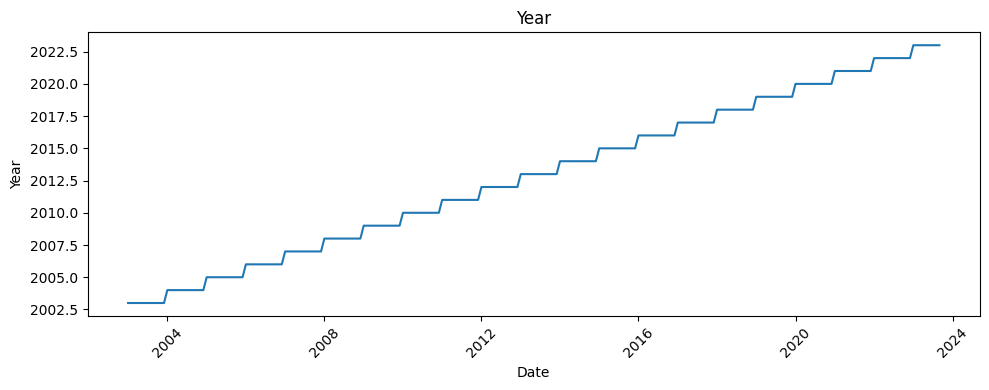

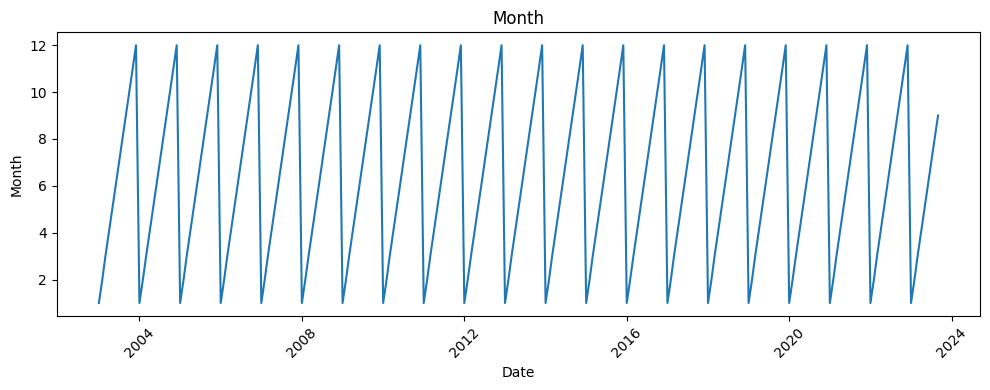

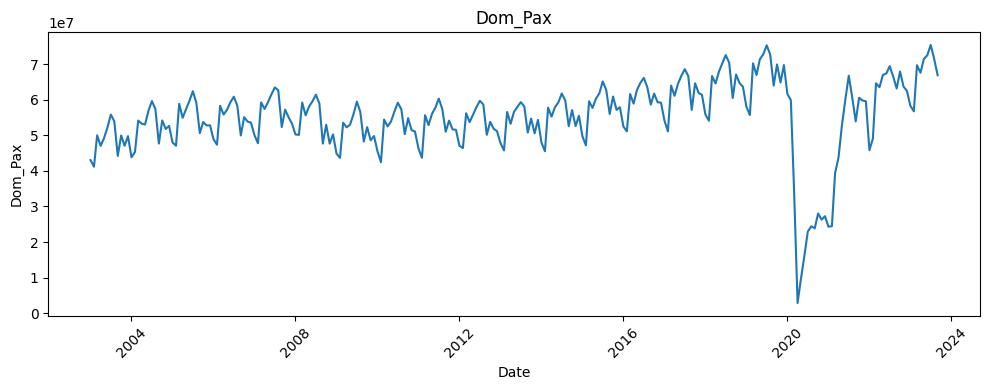

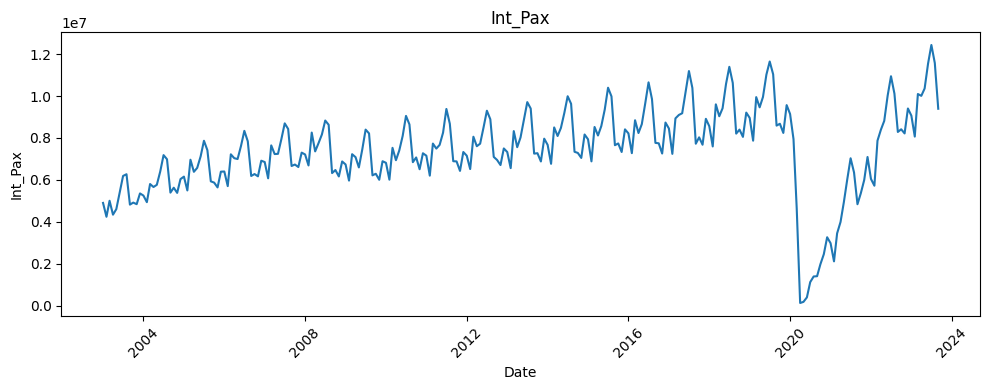

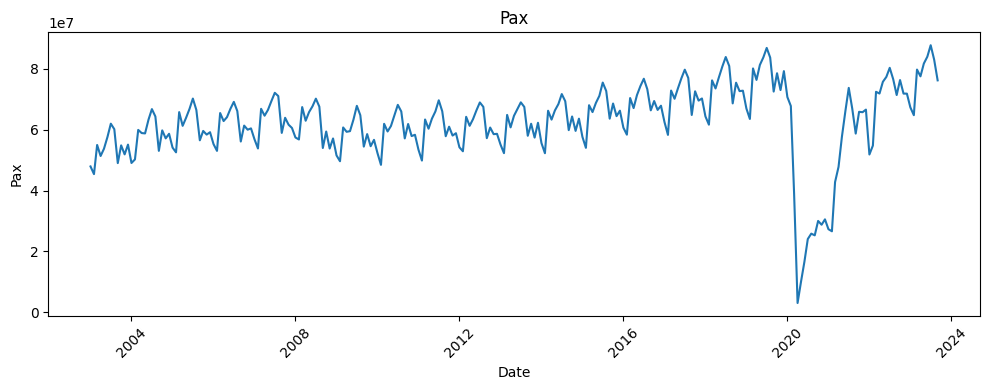

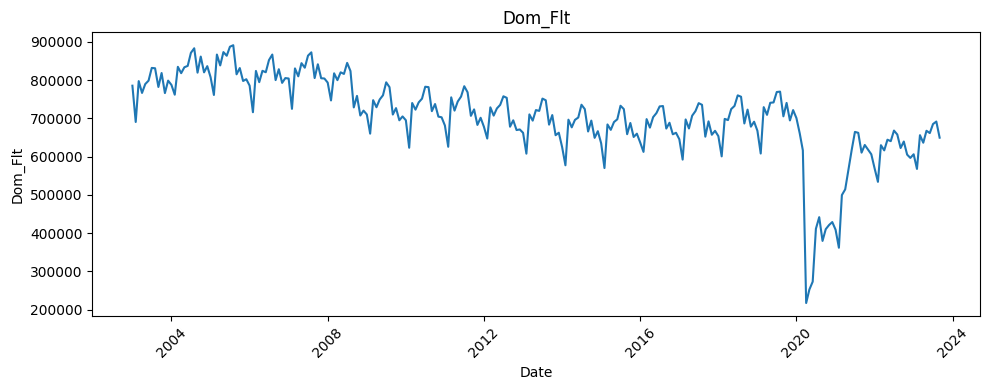

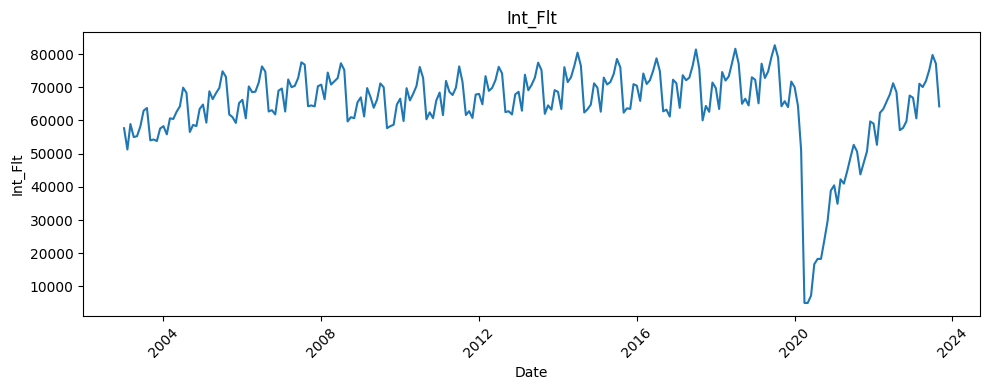

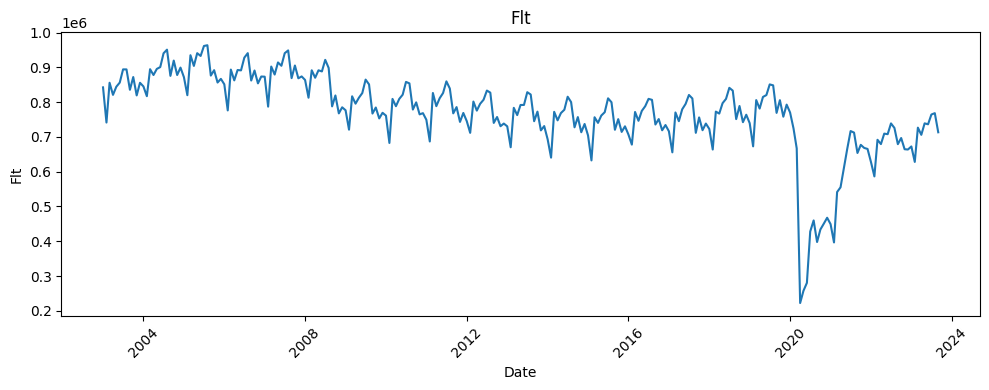

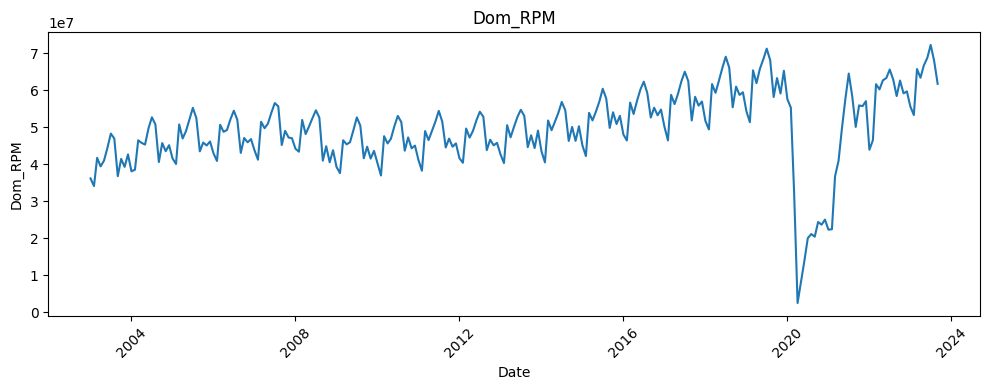

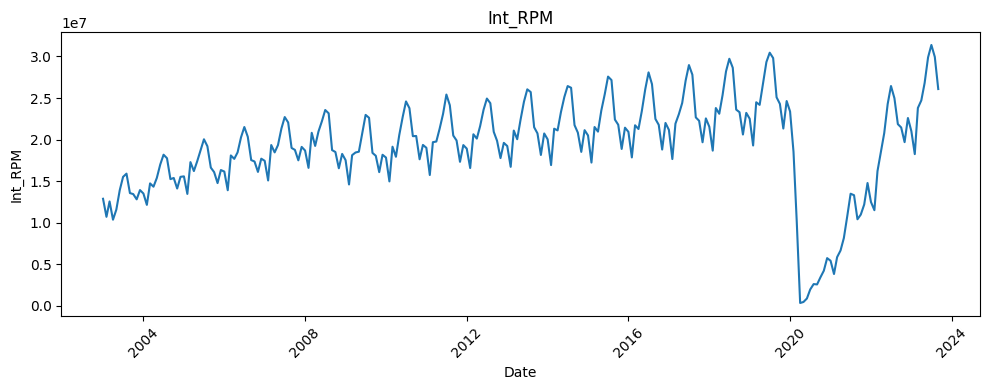

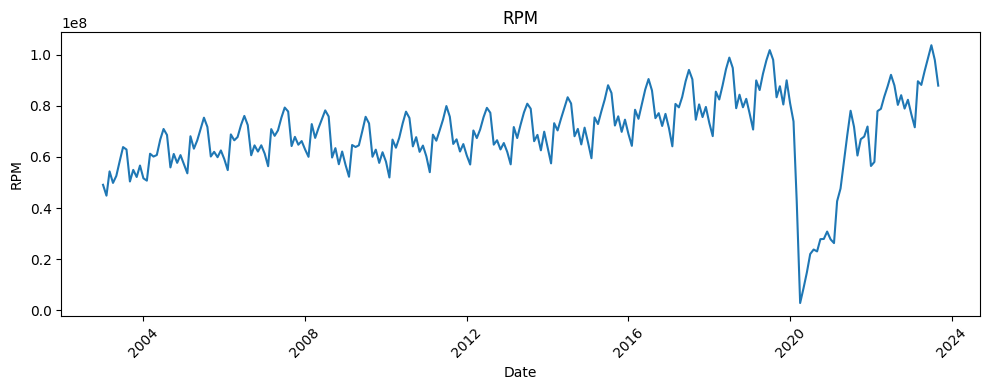

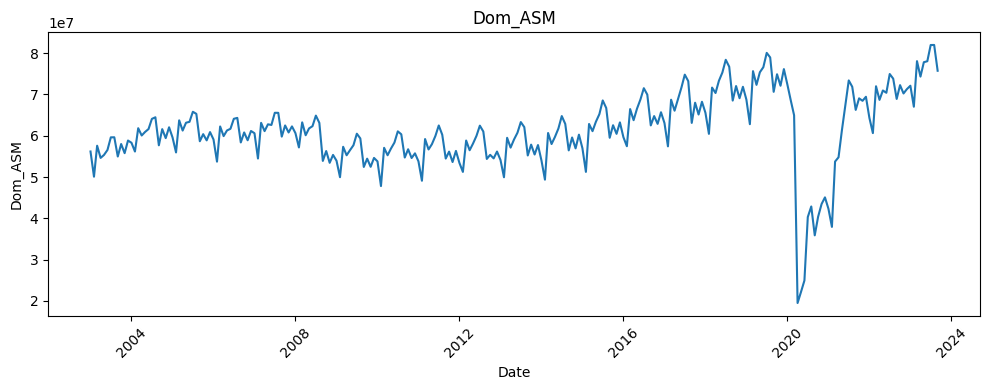

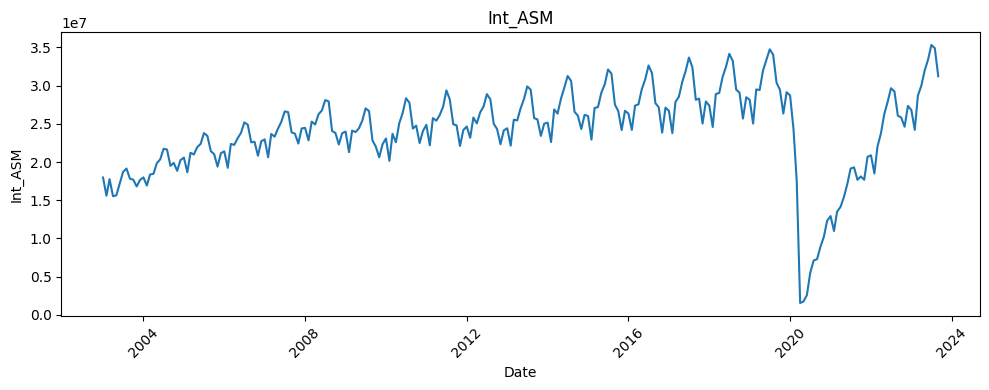

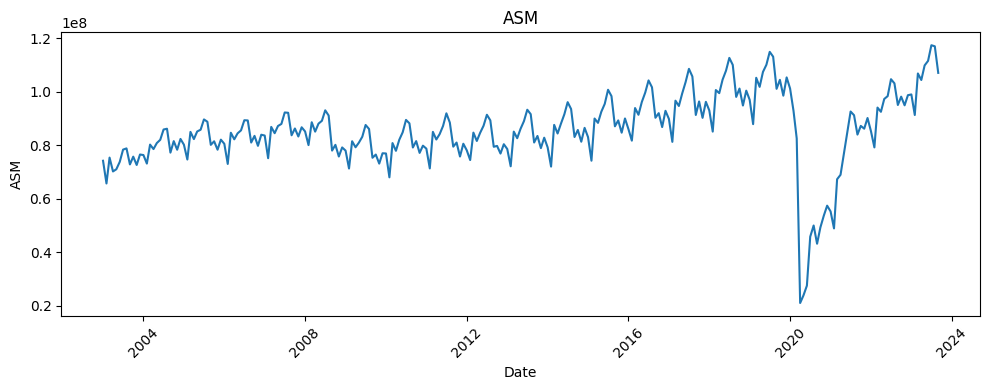

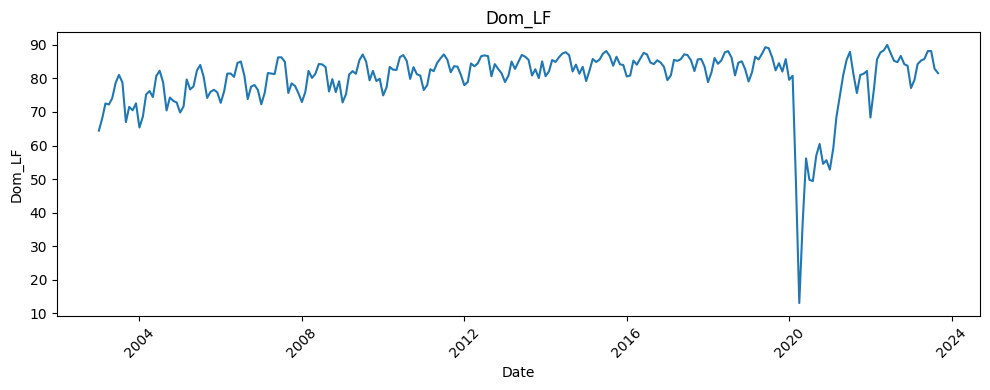

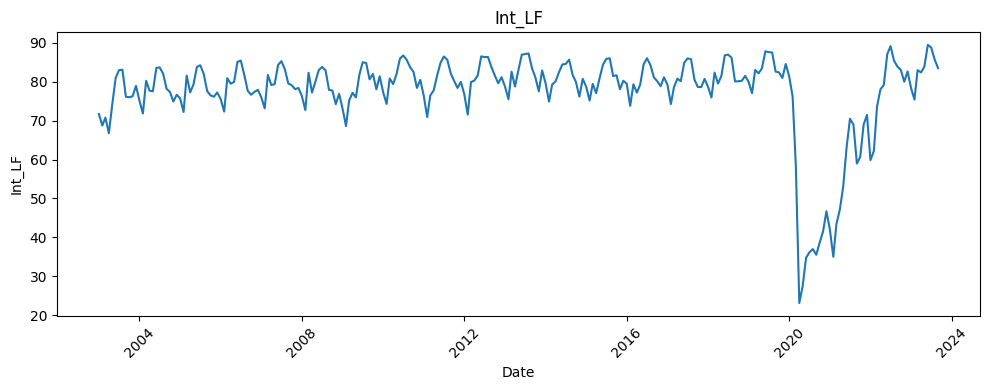

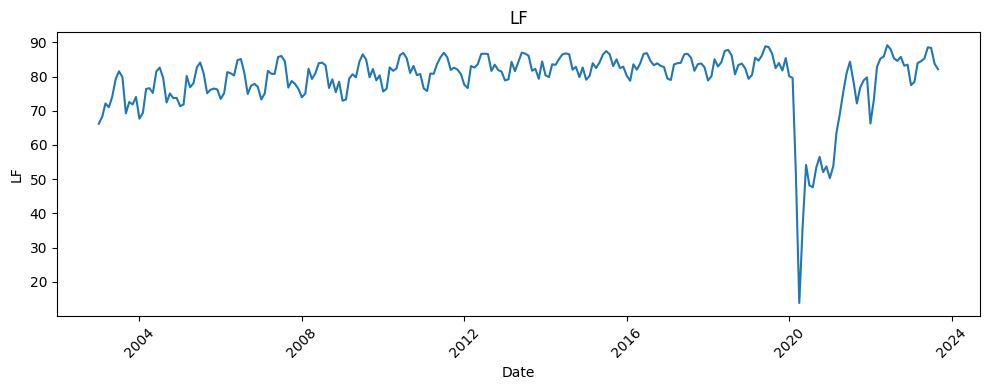

In [11]:
# lets see the trends of all the variables with respect to the date 
all_columns = [col for col in df.columns if col != 'Date']
for column in all_columns:
    plt.figure(figsize=(10, 4))  
    sns.lineplot(data=df, x='Date', y=column)
    plt.title(column)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

The covid impact is very noticable. 

for this time series project we are going to forecast Dom_RPM: Domestic Revenue Passenger Miles, which is a measure of airline traffic that calculates the number of miles flown by paying passengers on domestic flights. It's a key performance indicator for airlines, showing the volume of paid passenger travel within the country.

In [12]:
# so lets make a new & simpler df to work with 
new_df = df[['Date', 'Dom_RPM']].copy()
new_df['Date'] = pd.to_datetime(new_df['Date'])
new_df.set_index('Date', inplace=True)

In [13]:
# Split the data into training and testing sets
split_date = pd.to_datetime('2023-01-01')  
train = new_df.loc[:split_date]  
test = new_df.loc[split_date:]   

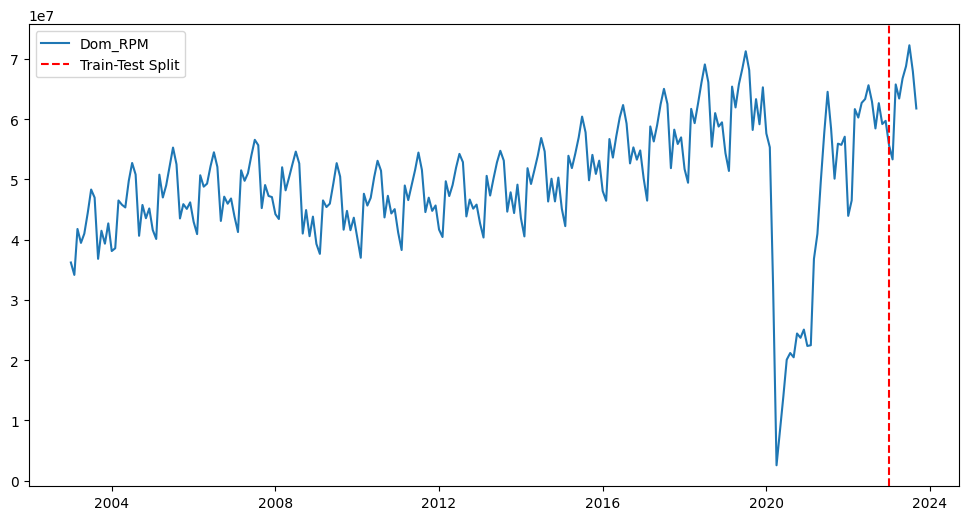

In [14]:
plt.figure(figsize=(12,6))
plt.plot(new_df.index, new_df['Dom_RPM'], label='Dom_RPM')
plt.axvline(x=split_date, color='red', linestyle='--', label='Train-Test Split')
plt.legend()
plt.show()

In [15]:
# stationarity check
from statsmodels.tsa.stattools import adfuller
st_train= adfuller(train['Dom_RPM'], autolag='AIC')
print(st_train)

(-3.4226696016299583, 0.010209919011204029, 13, 227, {'1%': -3.4594900381360034, '5%': -2.8743581895178485, '10%': -2.573601605503697}, 7463.150034343683)


The pre-differencing results indicated that the time series might be stationary at the 5% significance level, given the ADF statistic (-3.4227) is closer to the 5% critical value (-2.8744) and the p-value (0.0102) is below 0.05, suggesting the null hypothesis of a unit root can be rejected at this level.

Text(0.5, 1.0, "Autocorrelation Plot for 'Training Set'")

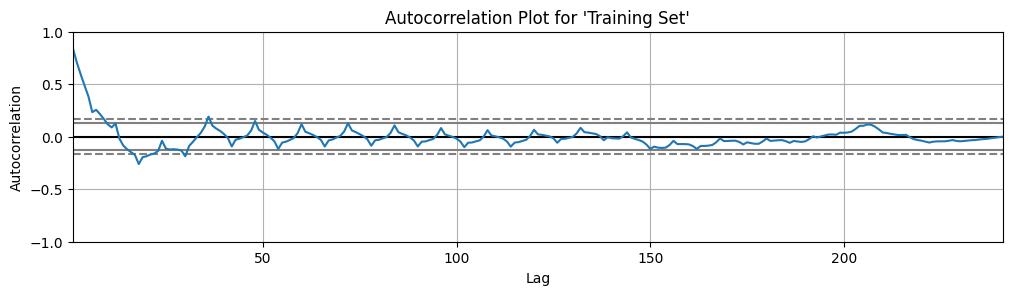

In [16]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
pd.plotting.autocorrelation_plot(train['Dom_RPM'])
plt.title(f"Autocorrelation Plot for 'Training Set'")

In [17]:
# differencing the training data 
train['Dom_RPM_diff'] = train['Dom_RPM'].diff().shift(-1)

In [18]:
train['Dom_RPM_diff'].isnull().sum()

1

In [19]:
train.tail()

,Dom_RPM,Dom_RPM_diff
Date,,
2022-09-01,58463970,4192893.0
2022-10-01,62656863,-3462566.0
2022-11-01,59194297,530209.0
2022-12-01,59724506,-4096763.0
2023-01-01,55627743,NaN


In [20]:
train = train.dropna()

In [21]:
# checking ADF reults after differencing
diff_st_train= adfuller(train['Dom_RPM'], autolag='AIC')
print(diff_st_train)

(-3.5346244529761273, 0.007141138016109167, 13, 226, {'1%': -3.4596204846395824, '5%': -2.8744153028455948, '10%': -2.5736320761218576}, 7429.093256516402)


After differencing, the ADF statistic becomes slightly more negative (-3.5346), and the p-value decreases further to 0.0071, enhancing the evidence against the null hypothesis of non-stationarity. The ADF statistic after differencing is still more negative than the 5% critical value and very close to the 1% critical value, suggesting stronger evidence of stationarity even at a stricter significance level.

In [22]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

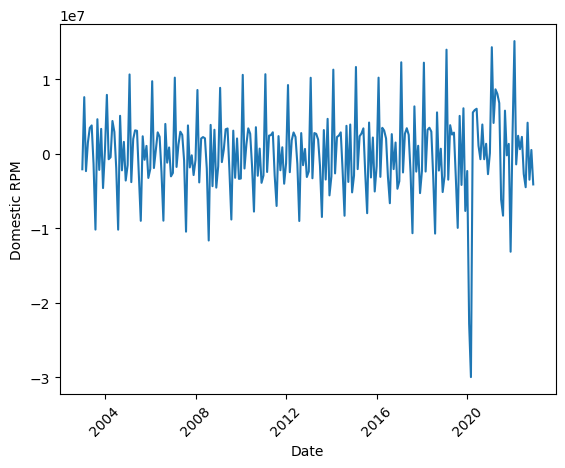

In [23]:
plt.plot(train.index, train['Dom_RPM_diff'])
plt.xlabel('Date')
plt.ylabel('Domestic RPM')
plt.xticks(rotation=45)
plt.show()

Here I did a basic ARIMA model to start

In [24]:
order = (1, 1, 1)
arima_model = sm.tsa.arima.ARIMA(train['Dom_RPM_diff'].dropna(), order=order)  
fitted = arima_model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:           Dom_RPM_diff   No. Observations:                  240
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4058.061
Date:                Wed, 31 Jan 2024   AIC                           8122.122
Time:                        00:04:39   BIC                           8132.552
Sample:                    01-01-2003   HQIC                          8126.325
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0813      0.052     -1.571      0.116      -0.183       0.020
ma.L1         -0.9967      0.076    -13.055      0.000      -1.146      -0.847
sigma2      4.056e+13    1.3e-15   3.11e+28      0.0

The log likelihood of -4058.061 and selection criteria such as AIC (8122.122), BIC (8132.552), and HQIC (8126.325), suggests that the model is  relatively efficienct in capturing the dynamics. The autoregressive term (ar.L1) at -0.0813 is not statistically significant (p-value: 0.116), which means that it might not contribute meaningfully to the model, whereas the moving average term (ma.L1) at -0.9967 is highly significant (p-value: 0.000), indicating a strong effect on the model. The error variance (sigma2) is large, at 4.056e+13, pointing to substantial unexplained variability.

the Ljung-Box test (p-value: 0.92) suggests no autocorrelation issues, but the Jarque-Bera test indicates the residuals do not follow a normal distribution (p-value: 0.00), and the heteroskedasticity test points to varying residual variances (p-value: 0.00), signaling potential model specification issues. Additionally, the residuals' skewness (-0.82) and high kurtosis (7.85) further question the model's assumptions. 

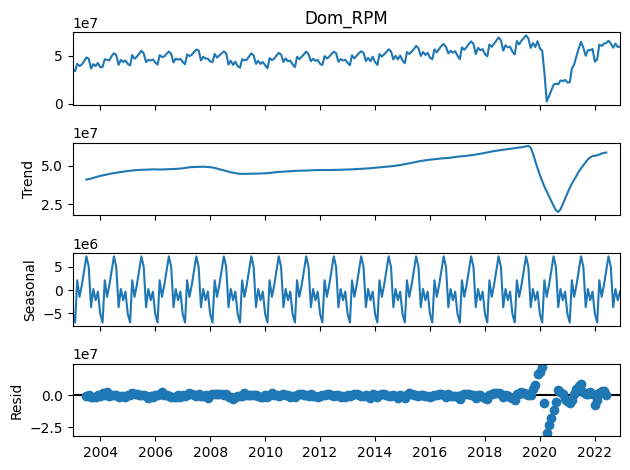

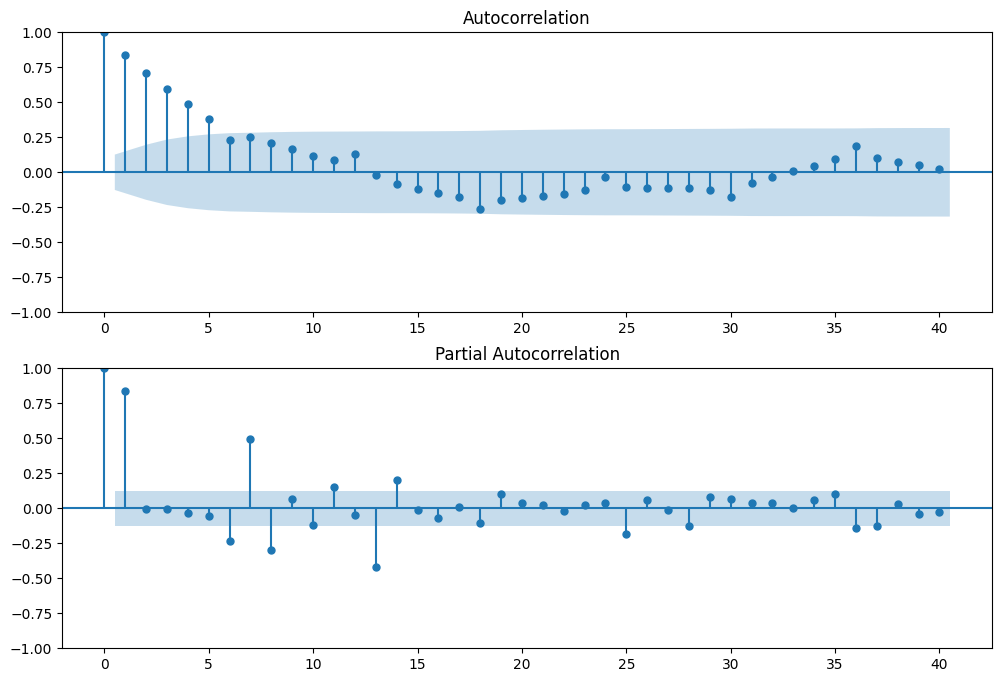

In [25]:
# decompose the time series to observe seasonal patterns
decomposition = sm.tsa.seasonal_decompose(train['Dom_RPM'], model='additive', period=12)  
decomposition.plot()
plt.show()

# ACF & PACF plots
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
sm.graphics.tsa.plot_acf(train['Dom_RPM'], lags=40, ax=ax1)  
sm.graphics.tsa.plot_pacf(train['Dom_RPM'], lags=40, ax=ax2)  
plt.show()


Getting ready now to run the SARIMA model, we have to specify the seasonal and non seasonal components.  

In [26]:
# non seasonal order 
p = 1 # number of lag observations in the model (AR term)
d = 1 # the number of times that the raw observations are differenced (I term)
q = 0  # the size of the moving average window (MA term)

# sasonal order
P = 0  # seasonal autoregressive order
D = 1  # essasonal differencing order
Q = 1  # seasonal moving average order
s = 12 # the number of periods in a season
seasonal_order = (P, D, Q, s)

In [27]:
sarima_model = sm.tsa.statespace.SARIMAX(train['Dom_RPM'],
                                          order=(p, d, q),
                                          seasonal_order=seasonal_order,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)

fitted_sarima = sarima_model.fit()
print(fitted_sarima.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.76948D+01    |proj g|=  6.32188D+01

At iterate    5    f=  1.47819D+01    |proj g|=  2.95769D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     12      1     0     0   7.109D-07   1.478D+01
  F =   14.781890403969348     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                      SARIMAX Results                                       
Dep. Variable:                         

 This problem is unconstrained.


The SARIMAX model shows a successful optimization process using the L-BFGS-B algorithm, converging after 8 iterations to a significantly improved model fit, with a final function value of 14.78. This SARIMAX model highlights both non-seasonal and seasonal dynamics within your data, with significant coefficients for both the autoregressive term (0.3927) and the seasonal moving average term (-0.6053), suggesting a notable autoregressive effect and a strong seasonal influence. 
The model's goodness-of-fit metrics, including a log likelihood of -3547.654 and criteria such as AIC (7101.307), BIC (7111.405), and HQIC (7105.388), provide a basis for evaluating model performance, with lower values generally indicating a better fit. However, diagnostic tests reveal residual distribution's normality and evidence of heteroskedasticity. 

Checking out the residuals of the model

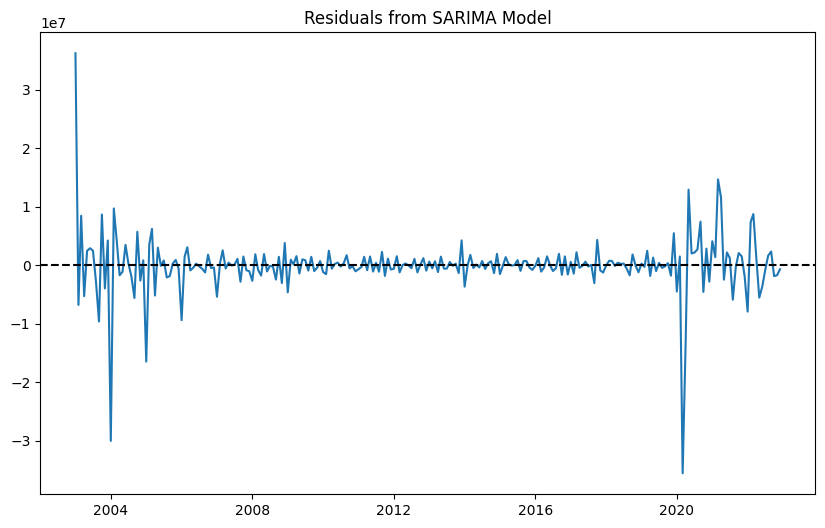

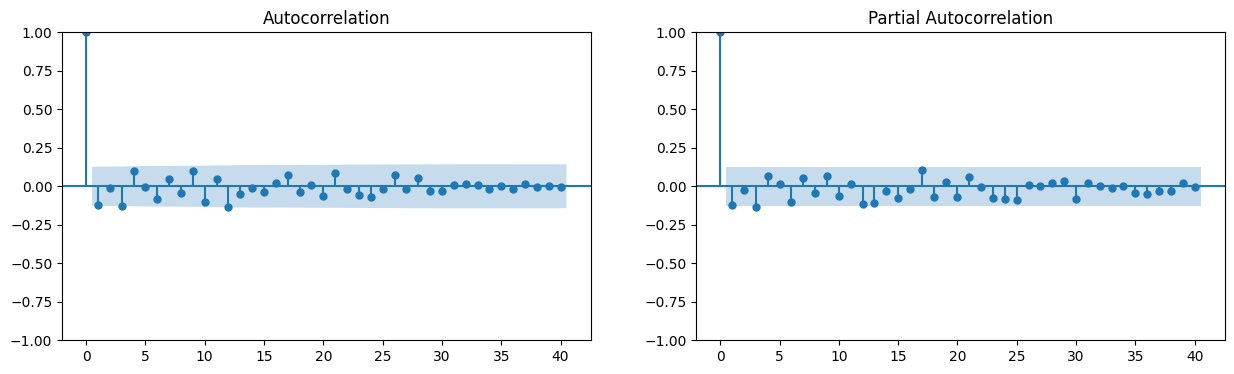

In [28]:
residuals = fitted_sarima.resid

# Plot the residuals
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals from SARIMA Model')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()# Plot ACF and PACF of the residuals
fig, ax = plt.subplots(1,2,figsize=(15,4))
sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax[1])
plt.show()

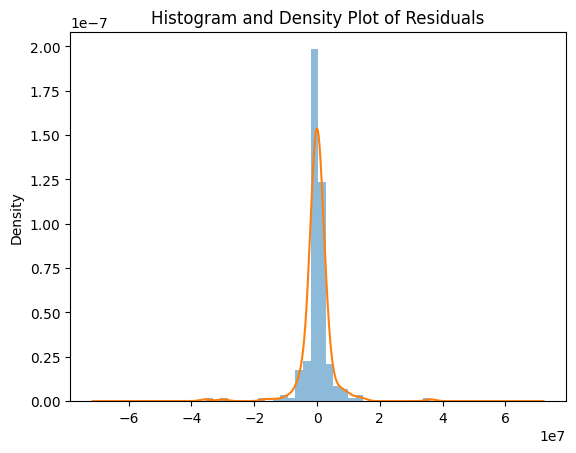

In [29]:
 # Histogram and kernel density estimate
residuals.plot(kind='hist', density=True, bins=30, alpha=0.5)
residuals.plot(kind='kde')
plt.title('Histogram and Density Plot of Residuals')
plt.show()

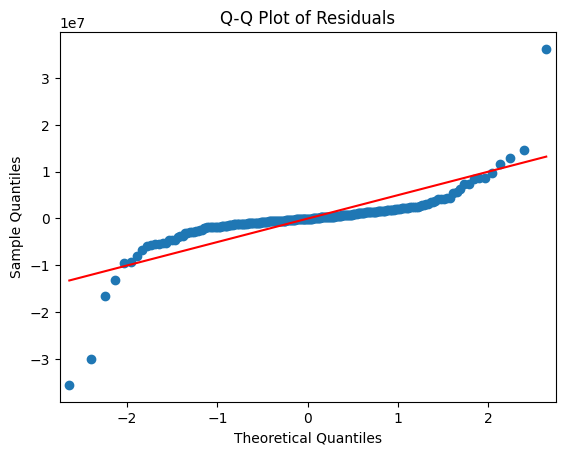

In [30]:
# Q-Q plot to check for normality
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

In [31]:
# statistical tests for normality
from scipy import stats
jb_test = stats.jarque_bera(residuals)
print(f'Jarque-Bera test statistics: {jb_test[0]}, p-value: {jb_test[1]}')

Jarque-Bera test statistics: 6792.539958302654, p-value: 0.0


The JB test statistic is very high, and the p-value is 0, which suggets the data doesn't follow a normal distribution. 

In [32]:
# statistical test for zero mean
mean_test = stats.ttest_1samp(residuals, 0)
print(f'Test Statistic: {mean_test.statistic}, p-value: {mean_test.pvalue}')

Test Statistic: -0.10122397282894008, p-value: 0.9194575337010837


Given the test statistic is very close to 0 and the p-value is very high (0.919), there is strong evidence to show that the mean of the residuals does not significantly differ from 0. In practical terms, this means that there is no significant bias in the residuals of the model; that is, the model is not systematically overestimating or underestimating the observed values.

In [33]:
# statistical test for autocorrelation
ljung_box_test = sm.stats.acorr_ljungbox(residuals, lags=[40], return_df=True)
print(ljung_box_test)

      lb_stat  lb_pvalue
40  35.096743   0.690385


The Ljung-Box test checks for autocorrelation at all lags up to 40 and tests the null hypothesis that there is no autocorrelation in the data. The relatively low statistic and the high p-value suggest that there's no significant evidence of autocorrelation in the residuals of the model up to 40 lags. 

 Dummies were incorporated into the SARIMA model to account for the impact of the COVID-19 pandemic on the time series data.

In [34]:
covid_start = '2020-03-01'  
covid_end = '2021-09-01'    

# creating a dummy variable for the covid period
train['covid_dummy'] = np.where((train.index >= covid_start) & (train.index <= covid_end), 1, 0)
# SARIMA model with an exogenous variable (the dummy variable)
sarimax_model1 = sm.tsa.statespace.SARIMAX(train['Dom_RPM'],
                                           exog=train['covid_dummy'],
                                           order=(p, d, q),
                                           seasonal_order=(P, D, Q, s),
                                           enforce_stationarity=False,
                                           enforce_invertibility=False)

fitted_sarimax1 = sarimax_model1.fit()
print(fitted_sarimax1.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50425D+01    |proj g|=  5.12549D+00

At iterate    5    f=  1.46920D+01    |proj g|=  8.23735D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     11      1     0     0   2.977D-06   1.469D+01
  F =   14.691945172187127     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


                                      SARIMAX Results                                       
Dep. Variable:                              Dom_RPM   No. Observations:                  240
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood               -3526.067
Date:                              Wed, 31 Jan 2024   AIC                           7060.134
Time:                                      00:04:44   BIC                           7073.598
Sample:                                  01-01-2003   HQIC                          7065.574
                                       - 12-01-2022                                         
Covariance Type:                                opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
covid_dummy -1.936e+07   6.63e+05    -29.201      0.000   -2.07e+07   -1.81e+07
ar.L1           

The optimization, using the L-BFGS-B algorithm, showed convergence after 9 iterations, revealing a significant and negative effect of the pandemic on the data as shown by the covid dummy coefficient (-1.936e+07). Both the autoregressive and seasonal moving average components were statistically significant, indicating the presence of important temporal dynamics. 
Despite a successful fit shown by various statistical metrics like AIC, BIC, and log likelihood, diagnostics indicated no significant autocorrelation in residuals but highlighted issues with non-normal distribution and heteroskedasticity. 

These two code snippets work together to build a more complex way of understanding the impact of covid on the data. In the first snippet, we calculate two things: the covid dummy, which tells us if covid was happening at a specific time, and the covid impact which measures how the influence of COVID-19 decreases as time goes on. 

Then, in the second snippet, we use these calculations to build a SARIMAX model. This model takes into account not just whether COVID-19 was around, but also how its effects changed over time. 

In [35]:
# lets try again but with decay
covid_start = pd.to_datetime('2020-03-01')
covid_end = pd.to_datetime('2021-09-01')
# calculating the number of days since the start of COVID-19 and convert to months by dividing by 30
train['months_since_covid'] = ((train.index - covid_start) / np.timedelta64(1, 'D') / 30).astype(int)
# linear decay
duration_in_months = ((covid_end - covid_start) / np.timedelta64(1, 'D') / 30)
train['covid_impact'] = train['months_since_covid'].apply(
    lambda x: max(1 - x / duration_in_months, 0) if x >= 0 else 0
)

In [36]:
sarimax_model_with_decay = sm.tsa.statespace.SARIMAX(
    train['Dom_RPM'],  
    exog=train[['covid_dummy', 'covid_impact']],
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
)

fitted_sarimax_with_decay = sarimax_model_with_decay.fit()
print(fitted_sarimax_with_decay.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50903D+01    |proj g|=  5.89958D+00

At iterate    5    f=  1.46961D+01    |proj g|=  8.25356D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     11      1     0     0   1.208D-06   1.470D+01
  F =   14.696124002402621     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


                                      SARIMAX Results                                       
Dep. Variable:                              Dom_RPM   No. Observations:                  240
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood               -3527.070
Date:                              Wed, 31 Jan 2024   AIC                           7064.140
Time:                                      00:04:45   BIC                           7080.969
Sample:                                  01-01-2003   HQIC                          7070.940
                                       - 12-01-2022                                         
Covariance Type:                                opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
covid_dummy  -1.934e+07   6.65e+05    -29.093      0.000   -2.06e+07    -1.8e+07
covid_impact 

In interpretation, the SARIMAX model with these coefficients suggests that the COVID-19 period had a substantial negative impact on the data (obviously..) with the covid dummy indicating a significant decrease. The covid impact coefficient suggests that the impact lessens as time moves forward, indicating a gradual recovery from the initial shock of the pandemic. 

Here we are forecasting for the next 12 months. It first generates a set of future dates, starting from the last date in the training data and spanning 12 months ahead. 
Then, it creates two arrays, future_covid_dummy and future_covid_impact, to represent the exogenous variables for the forecast. future_covid_dummy assumes that there will be no covid impact in the future, so it sets all values to 0 for the entire forecast period. While future_covid_impact assumes that the impact of COVID-19 gradually diminishes, with values decreasing from 0.5 to 0 over the 12-month forecast horizon. Then the arrays are combined into a df future_exog, which will be used as exogenous variables when making predictions. 

In [37]:
# number of periods to forecast(next 12 months)
n_periods = 12
future_dates = pd.date_range(train.index[-1] + pd.offsets.MonthBegin(), periods=n_periods, freq='M')
# assuming covid is starting go away, w impact from 0.5 to 0 
future_covid_dummy = [0] * n_periods  
future_covid_impact = np.linspace(start=0.5, stop=0, num=n_periods)  #
# combining into a df
future_exog = pd.DataFrame({'covid_dummy': future_covid_dummy, 'covid_impact': future_covid_impact}, index=future_dates)

In [38]:
n_periods = 12  
forecast = fitted_sarimax_with_decay.get_forecast(steps=n_periods, exog=future_exog)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

Below is the plot for the forecast. 

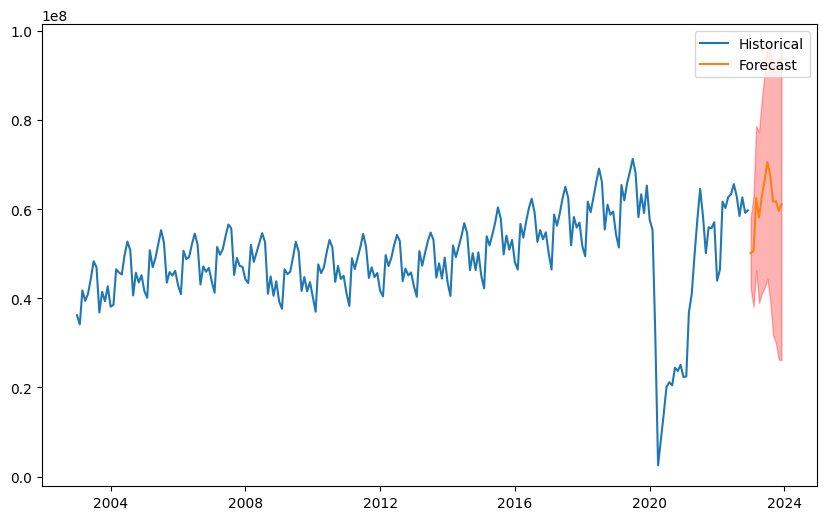

In [39]:
# plotting the forecast w the historicical data
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Dom_RPM'], label='Historical')
plt.plot(pd.date_range(train.index[-1], periods=n_periods, freq='M'), forecast_mean, label='Forecast')
plt.fill_between(pd.date_range(train.index[-1], periods=n_periods, freq='M'), forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='red', alpha=0.3)
plt.legend()
plt.show()


In [40]:
# lets compare our forecast w the test

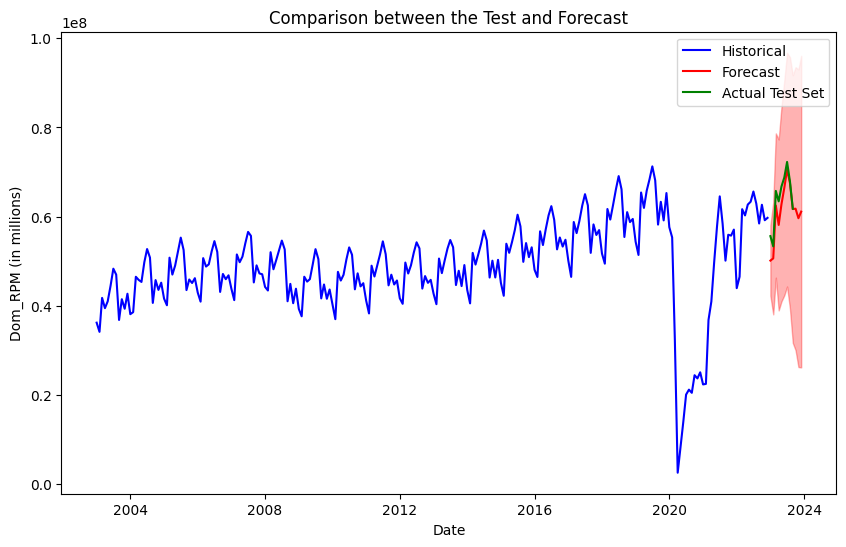

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Dom_RPM'], label='Historical', color='blue')
# forecast
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red')
# let's fill w  in the confidence interval
plt.fill_between(forecast_conf_int.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='red', alpha=0.3)
# test set
plt.plot(test.index, test['Dom_RPM'], label='Actual Test Set', color='green')

plt.title('Comparison between the Test and Forecast')
plt.xlabel('Date')
plt.ylabel('Dom_RPM (in millions)')
plt.legend()
plt.show()

The forecast is somewhat close to the actually test data. Although the forecast seems to have underestimated compared to the test set. 

That being said, dealing with the covid shock was quite the challenge. This is my first time series forecast dealing with the pandemic. Any tips or feedback would extremely helpful. 
<3